In [1]:
#need to get gauss1d working collumn 2
#on the big space at the bottom row

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
pi = math.pi

import csv
#from sklearn.cross_validation import train_test_split
import numpy as np
import argparse
from sklearn.utils import shuffle
#from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.models import load_model
import matplotlib.pyplot as plt

import pandas as pd
from time import time


import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
#from keras.callbacks import TensorBoard


Using TensorFlow backend.


In [3]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def matlab_style_log2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h1 = h*(x*x + y*y - 2.*sigma*sigma)/(sigma*sigma**2)
    h = h1 - sum(h1)/(shape[0]*shape[1])  
    return h

In [4]:
#function f=makefilter(scale,phasex,phasey,pts,sup)
#  gx=gauss1d(3*scale,0,pts(1,:),phasex);
#  gy=gauss1d(scale,0,pts(2,:),phasey);
#  f=normalise(reshape(gx.*gy,sup,sup));
#return
def makefilter(scale,phasex,phasey,pts,sup):
    gx=gauss1d(3*scale,0,pts[0,:],phasex);
    gy=gauss1d(scale,0,pts[1,:],phasey);
    f=normalise(np.reshape(gx*gy,(sup-1,sup-1)));
    return f

In [5]:
#function g=gauss1d(sigma,mean,x,ord)
#% Function to compute gaussian derivatives of order 0 <= ord < 3
#% evaluated at x.
#  x=x-mean;num=x.*x;
#  variance=sigma^2;
#  denom=2*variance; 
#  g=exp(-num/denom)/sqrt(pi*denom);
#  switch ord,
#    case 1, g=-g.*(x/variance);
#    case 2, g=g.*((num-variance)/(variance^2));
#  end;
#return
def gauss1d(sigma,mean,x,ord):
  x=x-mean
  num=x*x
  variance=sigma**2
  denom=2*variance
  g=np.exp(-num/denom)/np.sqrt(pi*denom)
  if (ord ==1):
    g=-g*(x/variance)
  elif (ord == 2):
    g=g*((num-variance)/(variance^2));
  return g

In [6]:
#function f=normalise(f), f=f-mean(f(:)); f=f/sum(abs(f(:))); return
def normalise(f):
    f = f-np.mean(f)
    f = f/np.sum(np.abs(f))
    return f

In [7]:
#  SUP=49;                 % Support of the largest filter (must be odd)
#  SCALEX=[1,2,4];         % Sigma_{x} for the oriented filters
#  NORIENT=6;              % Number of orientations
#  NROTINV=2;
#  NBAR=length(SCALEX)*NORIENT;
#  NEDGE=length(SCALEX)*NORIENT;
#  NF=NBAR+NEDGE+NROTINV;
#  F=zeros(SUP,SUP,NF);
#  hsup=(SUP-1)/2;
sup = 12
scalex = np.array([1,2])
norient =4
nrotinv = 2
nbar=len(scalex)*norient
nedge=len(scalex)*norient
nf=nbar+nedge+nrotinv
f = np.zeros([sup-1,sup-1,nf])
hsup = (sup-1)/2;

In [8]:
#  [x,y]=meshgrid([-hsup:hsup],[hsup:-1:-hsup]);
#  orgpts=[x(:) y(:)]';
xin = np.arange(-hsup, hsup, 1)
yin = np.arange(hsup,-hsup,-1)
x,y = np.meshgrid(xin,yin)
orgpts=np.array([x, y])
orgpts = np.reshape(orgpts,(2,(sup-1)**2))  ######needs work...



In [9]:
#  count=1;
#  for scale=1:length(SCALEX),
#    for orient=0:NORIENT-1,
#      angle=pi*orient/NORIENT;  % Not 2pi as filters have symmetry
#      c=cos(angle);s=sin(angle);
#      rotpts=[c -s;s c]*orgpts;
#      F(:,:,count)=makefilter(SCALEX(scale),0,1,rotpts,SUP);
#      F(:,:,count+NEDGE)=makefilter(SCALEX(scale),0,2,rotpts,SUP);
#      count=count+1;
#    end;
#  end; 

count=0
for scale  in range( len(scalex)):
    for orient in range(norient):
        angle=math.pi*orient/norient;  #Not 2pi as filters have symmetry
        c=math.cos(angle)
        s=math.sin(angle)      
        rotpts=np.matmul(np.array([[c, -s],[s, c]]),orgpts)
        f[:,:,count]=makefilter(scalex[scale],0,1,rotpts,sup)
        f[:,:,count+nedge]=makefilter(scalex[scale],0,2,rotpts,sup)
        count = count+1

       

In [10]:
#  F(:,:,NBAR+NEDGE+1)=normalise(fspecial('gaussian',SUP,10));
#  F(:,:,NBAR+NEDGE+2)=normalise(fspecial('log',SUP,10));

f[:,:,nbar+nedge]=normalise(matlab_style_gauss2D((sup-1,sup-1),10))
f[:,:,nbar+nedge+1]=normalise(matlab_style_log2D((sup-1,sup-1),10))
        


In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import numpy as np
%matplotlib inline

fig, axs = plt.subplots(6,8, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(38):
    axs[i].axis('off')
    axs[i].imshow(f[:,:,i])
    axs[i].set_title(i)

In [12]:
fh = open("tiny-imagenet-200/wnids.txt")
count = 0
yval = []
for line in fh:
    nl = ''
    for e in line:
        if e == '\n':
            break
        else:
            nl = nl+e
    yval.append(nl)
    #print(line)
    count+=1
fh.close()
print(count)


os.chdir('tiny-imagenet-200/train')
#list of folders
t2 = os.listdir()
#yval of list


cwd = os.getcwd()

#gets all x values... need to make y[200] oneshot array
#change t2[:10] for all pics and change x size
class_size = 200
size = 500*class_size


x = []
y = np.zeros([size,class_size])
c = 0
c2 = 0
for d in t2:
    #print(d)
    
    for f2 in os.listdir(d+'/images'):
        x.append(cwd+'\\'+d+'\\images\\'+f2)
        y[c,c2] = 1
        c = c+1
        
    c2+=1    
        
        #print(f2)

200


In [13]:
os.chdir('..')
os.chdir('..')

fh = open("tiny-imagenet-200/val/val_annotations.txt")
count = 0
yval = []
yspot = []
for line in fh:
    nl = ''
    nl2 = ''
    for e in line:
        if (e == '\t'):
            count +=1
        elif (count ==0):
            nl2 = nl2 +e
        elif (count == 1): 
            nl = nl+e
        elif count > 1: 
            break
    yval.append(nl)
    yspot.append(nl2)
    #print(line)
    count = 0
fh.close()


os.chdir('tiny-imagenet-200/train')
#list of folders
t3 = os.listdir()

os.chdir('..')
os.chdir('..')

os.chdir('tiny-imagenet-200/val/images')
#list of folders
t2 = os.listdir()
#yval of list


cwd = os.getcwd()

#gets all x values... need to make y[200] oneshot array
#change t2[:10] for all pics and change x size
class_size = 200
sizev = 10000


xv = []
yv = np.zeros([sizev,class_size])
c = 0
c2 = 0
for d in yspot:
    #print(d)
    
    #for f2 in os.listdir(d+'/images'):
    xv.append(cwd+'\\'+d)
    yv[c, t3.index(yval[c])] = 1
        #y[c,c2] = 1
    c = c+1
        
   # c2+=1   
        
        #print(f2)

In [14]:
import random

#X_test = np.sum(X_test/3, axis=3, keepdims=True)
def preprocess(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_out= img.astype('float32')
    #img_out=(img_out-img_out.mean())/img_out.std()
    img_out=img_out/255
    

    return img_out

def generator(x, y, batch_size=64):
    num_samples = len(x)
    x, y = shuffle(x, y)
    
    while True:
        images = []
        angles = []
        x, y = shuffle(x, y)
        for offset in range(0, num_samples, batch_size):
            images = []
            angles = []
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]
            if random.randint(0,1) ==0:
                for z in batch_x:
                    images.append(cv2.imread(z))
                for h in batch_y:
                    angles.append(h)
               
            else:
                for z in batch_x:
                    images.append(cv2.flip(cv2.imread(z), 1))
                for h in batch_y:
                    angles.append(h)
               
            X_train = np.array(images)
            y_train = np.array(batch_y)
            X_train = preprocess(X_train)
            
            yield X_train, y_train
            
def generator_filter(x, y, batch_size=128):
    num_samples = len(x)
    x, y = shuffle(x, y)
    while True:
        images = []
        angles = []
        figures = np.empty([64,64,54], dtype='float32')
        
        for offset in range(0, num_samples, batch_size):
            images = []
            figures = np.empty([64,64,54], dtype='float32')
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]
            
            for z in batch_x:
                
                imag=preprocess(cv2.imread(z))
                figures = np.empty([64,64,54], dtype='float32')
                for i in range(18):
                    figures[:,:,i*3:i*3+3] =  cv2.filter2D(imag,-1,f[:,:,i])
                images.append(figures)
                #images.append(cv2.filter2D(imag,-1,f[:,:,1]))
            for h in batch_y:
                angles.append(h)
            X_train = np.array(images)
            y_train = np.array(batch_y)
            #X_train = preprocess(X_train)
            
            yield X_train, y_train

x, y = shuffle(x, y)
train_generator = generator(x,y)
val_generator = generator(xv,yv)
#filter_generator = generator_filter(x,y)
#val_filter_generator = generator_filter(xv,yv)

In [15]:
z, g = next(train_generator)

In [16]:
img = tf.image.random_flip_left_right(z[0])

In [20]:

from keras.models import Sequential

TypeError: Image data cannot be converted to float

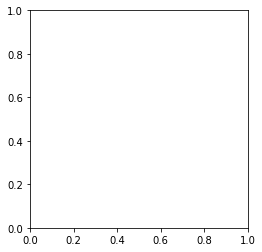

In [17]:
plt.imshow(img)

In [22]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=54, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(64,64,3)))
model.add(layers.MaxPooling2D())
#model.add(layers.AveragePooling2D(input_shape=(32,32,12)))

model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same',activation='relu'))

model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dropout(0.50))

model.add(layers.Dense(units=4096, activation='relu'))

#model.add(layers.Dense(units=2048, activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(units=2048, activation='relu'))

model.add(layers.Dense(units=class_size, activation = 'softmax'))



AttributeError: module 'keras' has no attribute 'Sequential'

In [19]:
model2 = keras.Sequential()

#model2.add(layers.Conv2D(filters=54, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model2.add(layers.MaxPooling2D(input_shape=(64,64,54)))
#model.add(layers.AveragePooling2D(input_shape=(32,32,12)))

model2.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model2.add(layers.MaxPooling2D())

model2.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

#model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

#model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same',activation='relu'))

model2.add(layers.MaxPooling2D())

model2.add(layers.Flatten())

model2.add(layers.Dropout(0.50))

#model.add(layers.Dense(units=4096, activation='relu'))

model2.add(layers.Dense(units=4096, activation='relu'))

model2.add(layers.Dense(units=2048, activation='relu'))

model2.add(layers.Dense(units=class_size, activation = 'softmax'))


AttributeError: module 'keras' has no attribute 'Sequential'

In [ ]:
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


m2 = model2.fit_generator(filter_generator, steps_per_epoch=size/128,epochs=15, validation_data = val_filter_generator, validation_steps = 10000/128)

In [ ]:
os.chdir('..')
os.chdir('..')
os.chdir('..')

#serialize model to JSON
model_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model2.h5")
print("Saved model to disk")

In [7]:
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
#                    validation_data=validation_generator, validation_steps=validation_steps, 
#                    shuffle=True, callbacks=[tensorboard])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
m = model.fit_generator(train_generator, steps_per_epoch=size/64,epochs=15
                        ,validation_data = val_generator, validation_steps = 10000/64)

Epoch 1/15
1563/1562 [==============================] - 228s 146ms/step - loss: 5.3050 - acc: 0.0044 - val_loss: 5.2983 - val_acc: 0.0050
Epoch 2/15
 730/1562 [=============>................] - ETA: 1:56 - loss: 5.2987 - acc: 0.0046

KeyboardInterrupt: 

In [ ]:
plt.plot(m2.history['val_acc'])
plt.plot(m2.history['acc'])

In [ ]:

plt.plot(m.history['val_acc'])
plt.plot(m.history['acc'])

In [ ]:
 #serialize model to JSON
os.chdir('..')
os.chdir('..')
os.chdir('..')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
m = model.fit_generator(train_generator, steps_per_epoch=size/128,epochs=15
                        ,validation_data = val_generator, validation_steps = 10000/128)

In [ ]:
os.chdir('..')
os.chdir('..')
os.chdir('..')

In [ ]:
fh = open("tiny-imagenet-200/val/val_annotations.txt")
count = 0
yval = []
yspot = []
for line in fh:
    nl = ''
    nl2 = ''
    for e in line:
        if (e == '\t'):
            count +=1
        elif (count ==0):
            nl2 = nl2 +e
        elif (count == 1): 
            nl = nl+e
        elif count > 1: 
            break
    yval.append(nl)
    yspot.append(nl2)
    #print(line)
    count = 0
fh.close()


os.chdir('tiny-imagenet-200/train')
#list of folders
t3 = os.listdir()

os.chdir('..')
os.chdir('..')

os.chdir('tiny-imagenet-200/val/images')
#list of folders
t2 = os.listdir()
#yval of list


cwd = os.getcwd()

#gets all x values... need to make y[200] oneshot array
#change t2[:10] for all pics and change x size
class_size = 200
size = 10000


xv = []
yv = np.zeros([size,class_size])
c = 0
c2 = 0
for d in yspot:
    #print(d)
    
    #for f2 in os.listdir(d+'/images'):
    xv.append(cwd+'\\'+d)
    yv[c, t3.index(yval[c])] = 1
        #y[c,c2] = 1
    c = c+1
        
   # c2+=1   
        
        #print(f2)

In [ ]:
def generator(x, y, batch_size=128):
    num_samples = len(x)
    x, y = shuffle(x, y)
    while True:
        images = []
        angles = []
        
        for offset in range(0, num_samples, batch_size):
            images = []
            batch_y = y[offset:offset + batch_size]
            batch_x = x[offset:offset + batch_size]
            
            for z in batch_x:
                images.append(cv2.imread(z))
            for h in batch_y:
                angles.append(h)
            X_train = np.array(images)
            y_train = np.array(batch_y)
            X_train = preprocess(X_train)
            
            yield X_train, y_train
            


In [ ]:
model.evaluate_generator(train_generator, steps = 50)

In [ ]:
from keras.models import model_from_json

with open('model2.json', 'r') as f:
    m = model_from_json(f.read())
m.load_weights('model2.h5')

In [ ]:
m.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
history = m.evaluate_generator(val_filter_generator, steps = 10000/128)

In [ ]:
history

In [ ]:
h = m.fit_generator(val_generator, steps_per_epoch=10000/256,epochs=10, validation_data = train_generator, validation_steps = 10000/256)

In [ ]:
history = m.evaluate_generator(val_generator, steps = 10000/128)

In [ ]:
history

In [ ]:
history = m.evaluate_generator(train_generator, steps = size/128)

In [ ]:
history